In [3]:
from Bio.PDB import PDBParser
import torch
from qres.structure_prediction import StructurePredictor
from IPython.display import HTML
from matplotlib.figure import Figure
import base64
import io
import py3Dmol
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path


palette = matplotlib.colormaps["magma_r"]
with open(Path("data/seqs_vis.json"), "r") as f:
    sequence_trajs = json.load(f)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
predictor = StructurePredictor(device=device)

Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
pdb_trajs = {}

for traj_name, seqs in sequence_trajs.items():
    pdbs = predictor.predict_structure(seqs)
    pdb_trajs[traj_name] = pdbs

In [47]:
pdb_trajs["L2"] = pdb_trajs["L2"][:4] + pdb_trajs["L2"][-3:-2]


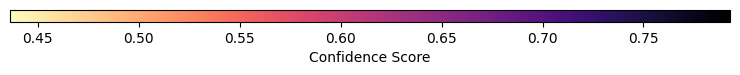

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

In [49]:
def parse_bs(pdb_str):
    i = 0
    bs = []
    idxs = []
    res_idxs = []
    for line in pdb_str.split("\n"):
        split = line.split()
        if len(split) == 0 or split[0] != "ATOM":
            continue
        res_idxs.append(int(split[5]))
        b = float(split[-2])
        assert b >= 0 and b <= 1
        bs.append(b)

        idx = int(split[1])
        idxs.append(idx)
        i += 1
    # average b over atoms in the same residue
    bs = np.array(bs)
    res_idxs = np.array(res_idxs)
    unique_res = np.unique(res_idxs)
    for idx in range(len(unique_res)):
        mask = res_idxs == unique_res[idx]
        bs[mask] = np.mean(bs[mask])
    return bs, idxs

def parse_bs_multi(pdbs):
    bs = []
    idxs = []
    for pdb in pdbs:
        bs_, idxs_ = parse_bs(pdb)
        bs.append(bs_)
        idxs.append(idxs_)
    return bs, idxs

def get_bs_data(pdbs):
    bs, idxs = parse_bs_multi(pdbs)
    bs_orig = bs.copy()
    # subtract min
    bs_min_orig = min([b.min() for b in bs])
    bs_max_orig = max([b.max() for b in bs])
    bs = [b - bs_min_orig for b in bs]
    # divide by max
    bs_max = max([b.max() for b in bs])
    bs = [b / bs_max for b in bs]
    return bs, idxs, bs_min_orig, bs_max_orig, bs_orig

def get_bw_color(value):
    color = '0x' + ''.join([hex(int(x*255))[2:].zfill(2) for x in palette(value)[:3]])
    return color

def get_mod_idx(seq1, seq2):
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            return i
    return -1

def view_traj(traj_id, n_cols=3):
    pdbs = pdb_trajs[traj_id]
    sequences = sequence_trajs[traj_id]
    titles = [f"Step {i}" for i in range(len(pdbs))]

    bs, idxs, bs_min_orig, bs_max_orig, bs_orig = get_bs_data(pdbs)

    n_structures = len(pdbs)
    n_rows = (n_structures + n_cols - 1) // n_cols  # Ceiling division
    
    # Create colorbar figure
    fig = Figure(figsize=(8, 0.4))
    ax = fig.add_axes([0.05, 0.5, 0.9, 0.3])
    norm = matplotlib.colors.Normalize(vmin=bs_min_orig, vmax=bs_max_orig)
    cb = matplotlib.colorbar.ColorbarBase(ax, cmap=palette,
                                        norm=norm,
                                        orientation='horizontal')
    cb.set_label('Confidence Score')
    
    # Convert colorbar to base64 string
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    colorbar_str = base64.b64encode(buf.getvalue()).decode('utf-8')
    
    # Generate HTML table
    html_str = '<table class="center" style="background-color: #ffffff">\n'
    
    # Add rows of structures
    for row in range(n_rows):
        # Title row
        html_str += '<tr>\n'
        for col in range(n_cols):
            idx = row * n_cols + col
            if idx < n_structures:
                html_str += f'<td><h3 style="text-align:center; color: #000000">{titles[idx]}</h3></td>\n'
        html_str += '</tr>\n'
        
        # Viewer row
        html_str += '<tr>\n'
        for col in range(n_cols):
            idx = row * n_cols + col
            if idx < n_structures:
                html_str += f'<td id="viewer_{idx}"></td>\n'
        html_str += '</tr>\n'

        # Sequence row
        html_str += '<tr>\n'
        for col in range(n_cols):
            idx = row * n_cols + col
            if idx < n_structures:
                sequence = sequences[idx]
                if idx > 0:
                    mod_idx = get_mod_idx(sequences[idx-1], sequence)
                    if mod_idx != -1:
                        # Wrap the modified character in a span with highlight style
                        sequence = (f"{sequence[:mod_idx]}"
                                f"<span style='color: red;'>{sequence[mod_idx]}</span>"
                                f"{sequence[mod_idx+1:]}")
                html_str += f'''<td style="background-color: #ffffff; padding: 0">
                            <p style="text-align:center; font-family:monospace; word-wrap:break-word; color: #000000">
                            {sequence}</p></td>\n'''
        html_str += '</tr>\n'

        # Add row for average confidence scores
        html_str += '<tr>\n'
        for col in range(n_cols):
            idx = row * n_cols + col
            if idx < n_structures:
                avg_confidence = sum(bs_orig[idx]) / len(bs_orig[idx])
                html_str += f'<td style="text-align:center; color: #000000; padding: 0; background-color: #ffffff">Confidence: {avg_confidence:.3f}</td>\n'
        html_str += '</tr>\n'
    
    # Add colorbar row at the bottom
    html_str += f'''
    <tr>
    <td colspan="{n_cols}" style="text-align: center;">
        <img src="data:image/png;base64,{colorbar_str}" style="display: block; margin: 0 auto;"/>
    </td>
    </tr>
    </table>
    '''

    # Display the HTML table
    display(HTML(html_str))
    
    # Create and display the 3D viewers
    for i in range(n_structures):
        width = 250
        view = py3Dmol.view(width=width, height=width)
        view.addModel(pdbs[i], "pdb")
        
        # Color the structure based on confidence scores
        for b, idx in zip(bs[i], idxs[i]):
            view.setStyle({'model': -1, 'serial': idx}, {"cartoon": {'color': get_bw_color(b)}})
        
        view.zoomTo()
        display(view.insert(f"viewer_{i}"))

view_traj("L3", n_cols=4)

In [12]:
def animate():
    # Initialize the 3D viewer
    view = py3Dmol.view(width=800, height=600)

    models = ""

    for i, pdb in enumerate(pdbs):
        models += "MODEL " + str(i) + "\n"
        models += str(pdb)
        models += "ENDMDL\n"

    view.addModelsAsFrames(models, "pdb")


    # view.setStyle({'model': -1}, {'cartoon': {'color': 'spectrum'}})


    # view.zoomTo()
    # view.animate({'loop': 'forward', 'interval': 5000})  # 1 second per frame
    for i_model, (bs_model, idxs_model) in enumerate(zip(bs, idxs)):
        for b, idx in zip(bs_model, idxs_model):
            # color = get_bw_color(b)
            view.setStyle({'model': i_model, 'serial': idx + 1}, {"cartoon": {"color": get_bw_color(b)}})
    # view.show()

In [14]:
def view_with_title(pdb_str, title, bs_data, idxs_data):
    # Create colorbar figure
    fig = Figure(figsize=(8, 0.4))
    ax = fig.add_axes([0.05, 0.5, 0.9, 0.3])
    norm = matplotlib.colors.Normalize(vmin=bs_min_orig, vmax=bs_max_orig)
    cb = matplotlib.colorbar.ColorbarBase(ax, cmap=palette,
                                        norm=norm,
                                        orientation='horizontal')
    cb.set_label('Confidence Score')
    
    # Convert figure to base64 string
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_str = base64.b64encode(buf.getvalue()).decode('utf-8')
    
    # Modified HTML template to include colorbar
    html_str = '''
    <table class="center" style="width:800px; background-color: #ffffff">
    <tr>
    <td><h2 style="text-align:center; color: #000000"> {0} </h2></td>
    </tr>
    <tr>
    <td id="viewer"></td>
    </tr>
    <tr>
    <td><img src="data:image/png;base64,{1}"/></td>
    </tr>
    </table>
    '''
    display(HTML(html_str.format(title, img_str)))
    
    # Rest of the visualization code remains the same
    view = py3Dmol.view(width=800, height=600)
    view.addModel(pdb_str, "pdb")
    
    for b, idx in zip(bs_data, idxs_data):
        view.setStyle({'model': 0, 'serial': idx}, {"cartoon": {'color': get_bw_color(b)}})
    
    view.zoomTo()
    display(view.insert("viewer"))

# Usage
# model_idx = 1
# title = f"Step {model_idx}"
# view_with_title(pdbs[model_idx], title, bs[model_idx], idxs[model_idx])

In [18]:
def get_mod_idx(seq1, seq2):
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            return i
    return -1

def view_structures_table(pdbs, titles, bs_data, idxs_data, n_cols=3):
    n_structures = len(pdbs)
    n_rows = (n_structures + n_cols - 1) // n_cols  # Ceiling division
    
    # Create colorbar figure
    fig = Figure(figsize=(8, 0.4))
    ax = fig.add_axes([0.05, 0.5, 0.9, 0.3])
    norm = matplotlib.colors.Normalize(vmin=bs_min_orig, vmax=bs_max_orig)
    cb = matplotlib.colorbar.ColorbarBase(ax, cmap=palette,
                                        norm=norm,
                                        orientation='horizontal')
    cb.set_label('Confidence Score')
    
    # Convert colorbar to base64 string
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    colorbar_str = base64.b64encode(buf.getvalue()).decode('utf-8')
    
    # Generate HTML table
    html_str = '<table class="center" style="background-color: #ffffff">\n'
    
    # Add rows of structures
    for row in range(n_rows):
        # Title row
        html_str += '<tr>\n'
        for col in range(n_cols):
            idx = row * n_cols + col
            if idx < n_structures:
                html_str += f'<td><h3 style="text-align:center; color: #000000">{titles[idx]}</h3></td>\n'
        html_str += '</tr>\n'
        
        # Viewer row
        html_str += '<tr>\n'
        for col in range(n_cols):
            idx = row * n_cols + col
            if idx < n_structures:
                html_str += f'<td id="viewer_{idx}"></td>\n'
        html_str += '</tr>\n'

        # Sequence row
        html_str += '<tr>\n'
        for col in range(n_cols):
            idx = row * n_cols + col
            if idx < n_structures:
                sequence = sequences[idx]
                if idx > 0:
                    mod_idx = get_mod_idx(sequences[idx-1], sequence)
                    if mod_idx != -1:
                        # Wrap the modified character in a span with highlight style
                        sequence = (f"{sequence[:mod_idx]}"
                                f"<span style='color: red;'>{sequence[mod_idx]}</span>"
                                f"{sequence[mod_idx+1:]}")
                html_str += f'''<td style="background-color: #ffffff; padding: 0">
                            <p style="text-align:center; font-family:monospace; word-wrap:break-word; color: #000000">
                            {sequence}</p></td>\n'''
        html_str += '</tr>\n'

        # Add row for average confidence scores
        html_str += '<tr>\n'
        for col in range(n_cols):
            idx = row * n_cols + col
            if idx < n_structures:
                avg_confidence = sum(bs_orig[idx]) / len(bs_orig[idx])
                html_str += f'<td style="text-align:center; color: #000000; padding: 0; background-color: #ffffff">Confidence: {avg_confidence:.3f}</td>\n'
        html_str += '</tr>\n'
    
    # Add colorbar row at the bottom
    html_str += f'''
    <tr>
    <td colspan="{n_cols}" style="text-align: center;">
        <img src="data:image/png;base64,{colorbar_str}" style="display: block; margin: 0 auto;"/>
    </td>
    </tr>
    </table>
    '''
    
    # Display the HTML table
    display(HTML(html_str))
    
    # Create and display the 3D viewers
    for i in range(n_structures):
        width = 250
        view = py3Dmol.view(width=width, height=width)
        view.addModel(pdbs[i], "pdb")
        
        # Color the structure based on confidence scores
        for b, idx in zip(bs_data[i], idxs_data[i]):
            view.setStyle({'model': -1, 'serial': idx}, {"cartoon": {'color': get_bw_color(b)}})
        
        view.zoomTo()
        display(view.insert(f"viewer_{i}"))

# Example usage:
titles = [f"Step {i}" for i in range(len(pdbs))]
view_structures_table(pdbs, titles, bs, idxs, n_cols=4)